## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.v2 as transformsv2
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
elif torch.backends.mps.is_available():
    print("The code will run on MPS (Apple Silicon GPU).")
    device = torch.device('mps')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [ ]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
size = 128

train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
train_transforms_extra = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor()
    ]
)
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64

trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
trainset_extra = Hotdog_NotHotdog(train=True, transform=train_transforms_extra)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
train_loader_extra = DataLoader(trainset_extra, batch_size=batch_size, shuffle=True)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Let's look at some images from our data 

In [ ]:
images, labels = next(iter(train_loader_extra))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [ ]:
class HotNotDog(nn.Module):
    def __init__(self):
        super(HotNotDog, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.fully_connected = nn.Sequential(
                nn.Linear((size//2)**2*64, 1000),
                nn.ReLU(),
                nn.Linear(1000, 2),
                nn.Softmax(dim=1))
    
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x
    
model = HotNotDog().to(device)
model.train()
# test

In [ ]:
from torchvision.models import resnet18, ResNet
from torchvision.models import ResNet18_Weights

resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

class LinearHead(nn.Module):
    def __init__(self, resnet_model: ResNet, out_features: int = 2):
        super(LinearHead, self).__init__()
        self.fc = nn.Linear(resnet_model.fc.out_features, out_features)
        self.softmax = nn.Softmax(dim=1)
        self.resnet_model = resnet_model
    
    def forward(self, x):
        x = self.resnet_model(x)
        x = self.fc(x)
        return x
    
model_resnet = LinearHead(resnet).to(device)

In [ ]:
num_epochs = 20

optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

# Initialize lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Best accuracy tracking
best_test_acc = 0.0
best_model_path = "best_model.pth"

for epoch in tqdm(range(num_epochs), unit='epoch'):
    # Training phase
    model_resnet.train()
    train_correct = 0
    train_loss = 0.0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_resnet(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        # Track training loss and accuracy
        train_loss += loss.item()
        predicted = output.argmax(1)
        train_correct += (target == predicted).sum().cpu().item()

    # Compute average training loss and accuracy for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / len(trainset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Testing phase
    model_resnet.eval()
    test_correct = 0
    test_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_resnet(data)
            test_loss += F.cross_entropy(output, target).item()
            predicted = output.argmax(1)
            test_correct += (target == predicted).sum().cpu().item()
    
    # Compute average test loss and accuracy for the epoch
    avg_test_loss = test_loss / len(test_loader)
    test_acc = test_correct / len(testset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
    
    # Save model if test accuracy improves
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model_resnet.state_dict(), best_model_path)
        print(f"New best test accuracy {100*test_acc:.1f}% at epoch {epoch+1}, model saved to {best_model_path}")

In [ ]:
train_losses
test_losses
train_accuracies
test_accuracies

In [ ]:
model_extra = HotNotDog().to(device)  # model trained with the extra data augmentation
model_extra.train()

optimizer = torch.optim.Adam(model_extra.parameters(), lr=0.001)

# Initialize lists to store metrics for custom CNN model
train_losses_extra = []
test_losses_extra = []
train_accuracies_extra = []
test_accuracies_extra = []

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    train_loss = 0.0
    model_extra.train()
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader_extra), total=len(train_loader_extra)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model_extra(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        # Track training loss
        train_loss += loss.item()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    
    # Compute average training loss and accuracy for the epoch
    avg_train_loss = train_loss / len(train_loader_extra)
    train_acc = train_correct / len(trainset)
    train_losses_extra.append(avg_train_loss)
    train_accuracies_extra.append(train_acc)
    
    #Comput the test accuracy
    model_extra.eval()
    test_correct = 0
    test_loss = 0.0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model_extra(data)
            test_loss += F.nll_loss(torch.log(output), target.to(device)).item()
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    
    # Compute average test loss and accuracy for the epoch
    avg_test_loss = test_loss / len(test_loader)
    test_acc = test_correct / len(testset)
    test_losses_extra.append(avg_test_loss)
    test_accuracies_extra.append(test_acc)
    
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

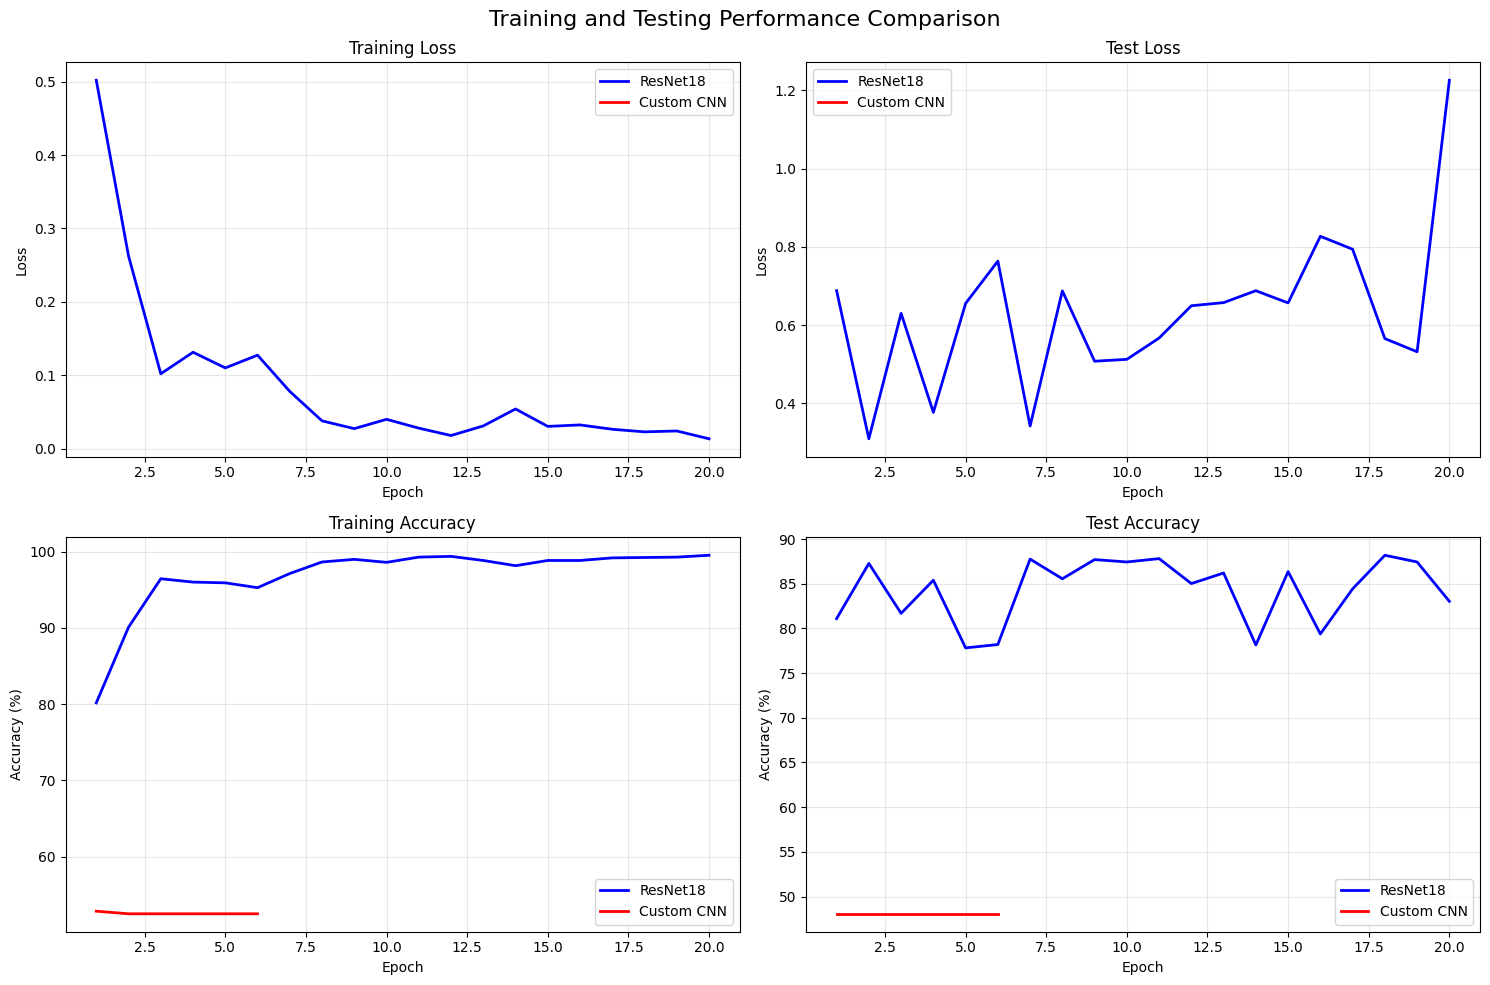

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training and Testing Performance Comparison', fontsize=16)

# Plot 1: Training Loss
axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='ResNet18', linewidth=2)
axes[0, 0].plot(range(1, len(train_losses_extra) + 1), train_losses_extra, 'r-', label='Custom CNN', linewidth=2)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test Loss
axes[0, 1].plot(range(1, len(test_losses) + 1), test_losses, 'b-', label='ResNet18', linewidth=2)
axes[0, 1].plot(range(1, len(test_losses_extra) + 1), test_losses_extra, 'r-', label='Custom CNN', linewidth=2)
axes[0, 1].set_title('Test Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Training Accuracy
axes[1, 0].plot(range(1, len(train_accuracies) + 1), [acc * 100 for acc in train_accuracies], 'b-', label='ResNet18', linewidth=2)
axes[1, 0].plot(range(1, len(train_accuracies_extra) + 1), [acc * 100 for acc in train_accuracies_extra], 'r-', label='Custom CNN', linewidth=2)
axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Test Accuracy
axes[1, 1].plot(range(1, len(test_accuracies) + 1), [acc * 100 for acc in test_accuracies], 'b-', label='ResNet18', linewidth=2)
axes[1, 1].plot(range(1, len(test_accuracies_extra) + 1), [acc * 100 for acc in test_accuracies_extra], 'r-', label='Custom CNN', linewidth=2)
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [20]:
print(f"\nResNet18 Model:")
print(f"  Final Training Accuracy: {train_accuracies[-1]*100:.1f}%")
print(f"  Final Test Accuracy: {test_accuracies[-1]*100:.1f}%")
print(f"  Best Test Accuracy: {max(test_accuracies)*100:.1f}%")
print(f"  Final Training Loss: {train_losses[-1]:.4f}")
print(f"  Final Test Loss: {test_losses[-1]:.4f}")

print(f"\nCustom CNN Model (with data augmentation):")
print(f"  Final Training Accuracy: {train_accuracies_extra[-1]*100:.1f}%")
print(f"  Final Test Accuracy: {test_accuracies_extra[-1]*100:.1f}%")
print(f"  Best Test Accuracy: {max(test_accuracies_extra)*100:.1f}%")
print(f"  Final Training Loss: {train_losses_extra[-1]:.4f}")
print(f"  Final Test Loss: {test_losses_extra[-1]:.4f}")

# Calculate improvement metrics
resnet_improvement = (test_accuracies[-1] - test_accuracies[0]) * 100
cnn_improvement = (test_accuracies_extra[-1] - test_accuracies_extra[0]) * 100

print(f"\nImprovement from first to last epoch:")
print(f"  ResNet18: {resnet_improvement:.1f} percentage points")
print(f"  Custom CNN: {cnn_improvement:.1f} percentage points")



ResNet18 Model:
  Final Training Accuracy: 99.5%
  Final Test Accuracy: 83.0%
  Best Test Accuracy: 88.2%
  Final Training Loss: 0.0134
  Final Test Loss: 1.2258

Custom CNN Model (with data augmentation):
  Final Training Accuracy: 52.5%
  Final Test Accuracy: 48.1%
  Best Test Accuracy: 48.1%
  Final Training Loss: nan
  Final Test Loss: nan

Improvement from first to last epoch:
  ResNet18: 1.9 percentage points
  Custom CNN: 0.0 percentage points


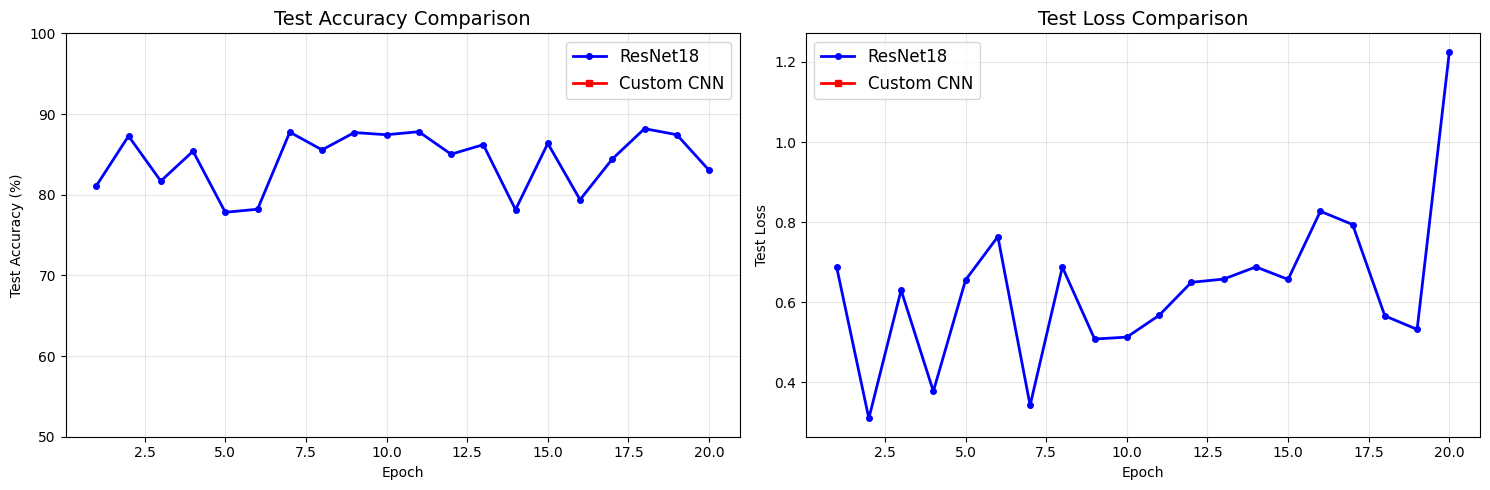

In [21]:
# Create a focused comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
axes[0].plot(range(1, len(test_accuracies) + 1), [acc * 100 for acc in test_accuracies], 'b-o', label='ResNet18', linewidth=2, markersize=4)
axes[0].plot(range(1, len(test_accuracies_extra) + 1), [acc * 100 for acc in test_accuracies_extra], 'r-s', label='Custom CNN', linewidth=2, markersize=4)
axes[0].set_title('Test Accuracy Comparison', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(50, 100)

# Loss comparison
axes[1].plot(range(1, len(test_losses) + 1), test_losses, 'b-o', label='ResNet18', linewidth=2, markersize=4)
axes[1].plot(range(1, len(test_losses_extra) + 1), test_losses_extra, 'r-s', label='Custom CNN', linewidth=2, markersize=4)
axes[1].set_title('Test Loss Comparison', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Loss')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
